In [ ]:
import sys
import os

current_notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root_dir = os.path.abspath(os.path.join(current_notebook_dir, '../../'))

# 将这个父目录添加到sys.path的最前面
if project_root_dir not in sys.path:
    sys.path.insert(0, project_root_dir)

print(sys.path)

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from pytorch_script.visual_utils import load_cifar10_data, \
	get_sorted_model_paths, evaluate_model_performance, load_model_state_dict


In [ ]:
import seaborn as sns

config = {
	'model_dir': '../../model_training_results/cifar10_resnet20',  # 模型存储的文件夹路径
	'model_prefix': 'model_',        # 模型文件名的前缀
	'model_extension': '.pth',                         # 保存模型的文件扩展名
	'cifar10_data_path': '../../pytorch_script/data/cifar10',           # CIFAR-10 数据集存储路径
	'batch_size': 64,                                 # DataLoader 的批次大小
	'num_workers': 2                                  # DataLoader 的工作进程数
}

device = torch.device("cuda")

# 加载数据
train_loader, test_loader = load_cifar10_data(
	config['cifar10_data_path'], config['batch_size'], config['num_workers']
)
if train_loader is None or test_loader is None:
	print("数据加载失败，程序终止。")

# 获取排序后的模型文件路径
sorted_model_paths = get_sorted_model_paths(
	config['model_dir'], config['model_prefix'], config['model_extension']
)

In [40]:
import torch
import torch.nn.functional as F
from collections import defaultdict

def get_loss_distribution_predict_res(model, dataloader):
	# 假设这是您的评估循环片段
	all_losses = []
	all_correct_preds = [] # True if correctly classified, False otherwise

	model.eval()
	with torch.no_grad():
		for data, labels in dataloader:
			outputs = model(data)
			# 计算逐样本损失，确保loss_fn支持 reduction='none'
			# 如果您的损失函数默认就是reduction='mean'或'sum'，您需要确保能获取到每个样本的损失
			# 例如，对于nn.CrossEntropyLoss
			per_sample_loss = F.cross_entropy(outputs, labels, reduction='none')
			all_losses.extend(per_sample_loss.tolist())

			_, predicted = torch.max(outputs.data, 1)
			correct_preds = (predicted == labels).cpu().numpy()
			all_correct_preds.extend(correct_preds.tolist())

	# 将数据转换为numpy数组以便后续处理
	all_losses_np = np.array(all_losses)
	all_correct_preds_np = np.array(all_correct_preds)

	return all_losses_np, all_correct_preds_np

In [ ]:
def visualize_data(all_losses_np, all_correct_preds_np, title="Loss Distribution"):
	"""
	可视化损失分布，区分正确分类和错误分类的样本。

	Args:
		all_losses_np (np.array): 所有样本的损失数组。
		all_correct_preds_np (np.array): 布尔数组，True表示正确分类，False表示错误分类。
		title (str): 图表的标题。
	"""

	correct_losses = all_losses_np[all_correct_preds_np == True]
	incorrect_losses = all_losses_np[all_correct_preds_np == False]

	# 确定直方图的 bins（边界），以便两组损失使用相同的 bins
	# 使用所有损失来确定合适的 bins 范围
	bins = np.histogram_bin_edges(all_losses_np, bins='auto') # 或者指定具体数量，如 bins=50

	plt.figure(figsize=(10, 6))

	# 绘制堆叠柱状图
	# label用于图例
	plt.hist(
		[correct_losses, incorrect_losses], # 传递一个列表，包含要堆叠的数据
		bins=bins,                         # 使用相同的 bins
		stacked=True,                      # 关键参数，设置为True实现堆叠
		color=['#66c2a5', '#fc8d62'],      # 设置两种颜色，例如绿色（正确）和橙色（错误）
		label=['Correctly Classified', 'Misclassified'], # 图例标签
		edgecolor='black'                  # 柱子边缘线
	)
	
	plt.title(title + " (Correct vs. Misclassified)")
	plt.xlabel("Loss Value")
	plt.ylabel("Number of Samples")
	plt.legend() # 显示图例
	plt.grid(axis='y', alpha=0.75)
	plt.show()

  从字典中提取模型状态字典...


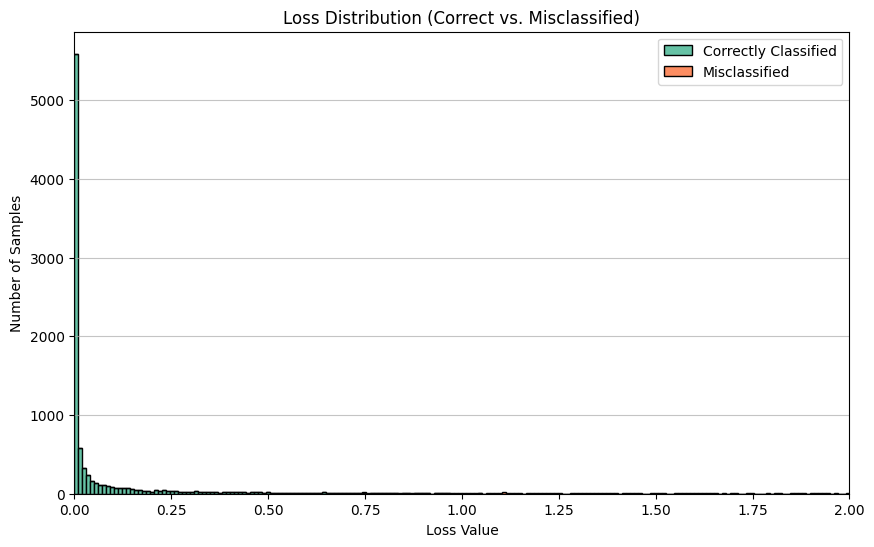

In [23]:
model_path = '../../model_training_results/cifar10_resnet20/model_100.pth'
model = load_model_state_dict('cifar10', 'resnet20', 10, model_path, device)
all_losses_np, all_correct_preds_np = get_loss_distribution_predict_res(model, test_loader)
visualize_data(all_losses_np, all_correct_preds_np)

In [19]:
np.mean(all_losses_np)

np.float64(0.29007720146242494)

In [25]:
import pickle
with open('all_model_test_losses.pickle', 'rb') as f: 
	all_model_test_losses = pickle.load(f)

In [39]:
np.any(np.array(all_model_test_losses[100]) > 1)

np.False_

In [36]:

np.any(np.array(all_losses_np) > 6)

np.True_